# Adversarial Learning against Intrusion Detection Systems

In this notebook, we examine the feasibility of adversarial learning in the context of Intrusion Detection. We use the CICIDS2017 dataset and create a learning model to perform binary classification against this. We then study how this holds against FGSM attacks, and the amount of perturbation required to create a false result. We then explore how different parameter counts hold against this attack vector, to assess the robustness of the feature sets being used for learning.

In [ ]:
!pip install -q tensorflow==2.0.0b1
# Install bleeding edge version of cleverhans
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

import cleverhans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

     |████████████████████████████████| 87.9MB 66kB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 3.1MB 60.6MB/s 
     |████████████████████████████████| 501kB 55.4MB/s 
  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-ndpjluqc/cleverhans
  Running command git clone -q https://github.com/tensorflow/cleverhans.git /tmp/pip-install-ndpjluqc/cleverhans
     |████████████████████████████████| 163kB 13.9MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
  Created wheel for cleverhans: filename=cleverhans-3.0.1-cp36-none-any.whl size=262573 sha256=23175c8bb92e9f00b75e45ebef69ba60bc35aa8dbd017b466b5cd9be53acd742
  Stored in directory: /tmp/pip-ephem-wheel-cache-whmc9adc/wheels/6e/59/ec/723a6f654aaf62c8c40f0f0850fdf71a4948598697f56c3bfa
Successfully built cleverhans


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 


Tensorflow Version: 2.0.0-beta1
Cleverhans Version: 3.0.1-15447acccf2628751c1e44ee30e141ec
GPU Available:  False


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

## GPUs


In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

## Load in the Dataset

We will load in the CICIDS 2017 - this can be used either based on the binary class or the multi-class label.

In [ ]:
import pandas as pd
import sys as sys



from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from google.colab import drive
drive.mount('./mount')
print("Drive Mounted")

dataset = pd.read_csv('mount/My Drive/Colab Notebooks/CICIDS2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
dataset = dataset.iloc[0:50000,:]

#dataset = pd.read_csv('mount/My Drive/Colab Notebooks/network_data/CICIDS2017_dataset.csv')
#dataset = pd.read_csv('mount/My Drive/Colab Notebooks/network_data/CICIDS2017_FeatureImportancesWithoutRankings.csv')
print ("Dataset Shape", dataset.shape)
print(dataset)
# Creating X and Y from the dataset
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(dataset[' Label'])
Y_attack = le.transform(dataset[' Label']) # multi-class 

#print(list(le.classes_))
#print(np.unique(Y_attack))

print("Dropping Flow Bytes and Flow Packets")
dataset = dataset.drop(columns='Flow Bytes/s')
dataset = dataset.drop(columns=' Flow Packets/s')




print("Big Differences")
# 'Fwd PSH Flags'
# ' ACK Flag Count'
# 'Bwd Packet Length Max'
# ' Max Packet Length'
# ' Packet Length Mean'

print(dataset.columns)





# Transform Objects to Digits
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for column_name in dataset.columns:
        if dataset[column_name].dtype == object:
            print(dataset[column_name])
            dataset[column_name] = le.fit_transform(dataset[column_name])
        else:
            pass


Y_class = dataset.iloc[:,-1].values # binary
X = dataset.iloc[:,0:80].values



X = X.astype(float)

#print(dataset.max())
#print (dataset.dtypes)
#print((dataset.isnull).sum())

# Performing scale data
scaler = MinMaxScaler().fit(X)
X_scaled = np.array(scaler.transform(X))

Mounted at ./mount
Drive Mounted
Dataset Shape (50000, 79)
        Destination Port   Flow Duration  ...   Idle Min   Label
0                  54865               3  ...          0  BENIGN
1                  55054             109  ...          0  BENIGN
2                  55055              52  ...          0  BENIGN
3                  46236              34  ...          0  BENIGN
4                  54863               3  ...          0  BENIGN
...                  ...             ...  ...        ...     ...
49995                 53             254  ...          0  BENIGN
49996                 53             208  ...          0  BENIGN
49997                 53             214  ...          0  BENIGN
49998                 53             252  ...          0  BENIGN
49999                 53             247  ...          0  BENIGN

[50000 rows x 79 columns]
Dropping Flow Bytes and Flow Packets
Big Differences
Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Tota

## kfold



In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)


## Binary Classification

Dropping  PSH Flag Count
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 46us/sample - loss: 0.0141 - accuracy: 0.9991
Epoch 2/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.1462e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.4352e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 5.7234e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 44us/sample - loss: 3.0075e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.9372e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.4634e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.27

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 45us/sample - loss: 0.0147 - accuracy: 0.9977
Epoch 2/10
40000/40000 [==============================] - 2s 44us/sample - loss: 8.7192e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 44us/sample - loss: 2.4057e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 9.5589e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 45us/sample - loss: 4.5825e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 44us/sample - loss: 2.5755e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 45us/sample - loss: 1.7219e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.3703e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.2400e-07 -

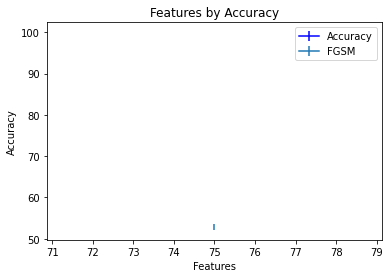

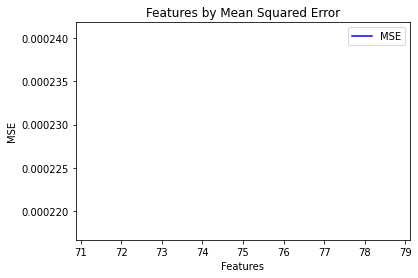

Dropping  ACK Flag Count
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0127 - accuracy: 0.9989
Epoch 2/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.1613e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 44us/sample - loss: 3.2104e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.2755e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 43us/sample - loss: 6.0345e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 44us/sample - loss: 3.3101e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 44us/sample - loss: 2.1058e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.5683e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 43us/sa

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0144 - accuracy: 0.9972
Epoch 2/10
40000/40000 [==============================] - 2s 43us/sample - loss: 8.6394e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.3535e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 9.5085e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 44us/sample - loss: 4.6672e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.6955e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.8145e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.4354e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2833e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 45us/sample - loss: 0.0140 - accuracy: 0.9987
Epoch 2/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.0534e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.9952e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.1935e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 44us/sample - loss: 5.6532e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 43us/sample - loss: 3.1036e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.9795e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.5194e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.3204e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


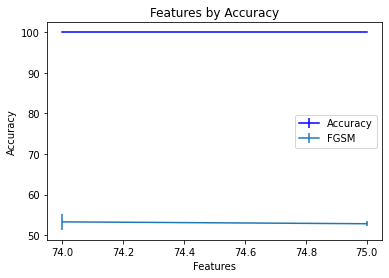

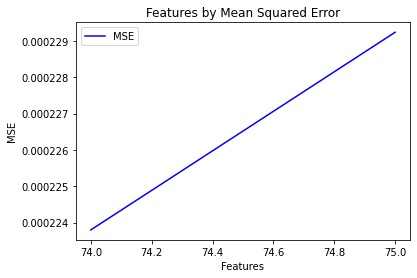

Dropping Bwd Packet Length Max
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0124 - accuracy: 0.9990
Epoch 2/10
40000/40000 [==============================] - 2s 42us/sample - loss: 7.3213e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.8985e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 42us/sample - loss: 7.6617e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 42us/sample - loss: 3.8577e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.3240e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.6429e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.3536e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 4

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0147 - accuracy: 0.9983
Epoch 2/10
40000/40000 [==============================] - 2s 43us/sample - loss: 8.3873e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.0764e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 43us/sample - loss: 7.8411e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 43us/sample - loss: 3.7385e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.1622e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.5449e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.3274e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.2400e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0169 - accuracy: 0.9973
Epoch 2/10
40000/40000 [==============================] - 2s 43us/sample - loss: 5.5692e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.4514e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 43us/sample - loss: 5.9018e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 43us/sample - loss: 3.0532e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.9223e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.4914e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.3113e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2435e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0156 - accuracy: 0.9976
Epoch 2/10
40000/40000 [==============================] - 2s 42us/sample - loss: 9.2248e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.4776e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 42us/sample - loss: 9.8270e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 42us/sample - loss: 4.7438e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.7063e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.8235e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.4317e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2819e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


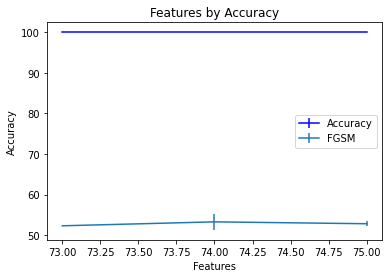

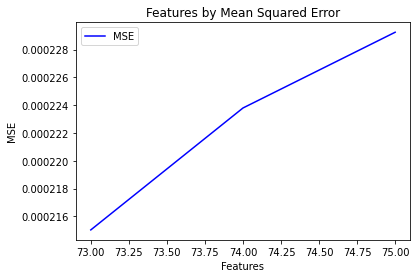

Dropping  Max Packet Length
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0141 - accuracy: 0.9980
Epoch 2/10
40000/40000 [==============================] - 2s 43us/sample - loss: 5.0405e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.4135e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 42us/sample - loss: 5.9224e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 43us/sample - loss: 3.1249e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.9836e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.4927e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.3038e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0142 - accuracy: 0.9984
Epoch 2/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.1206e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 42us/sample - loss: 3.1210e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.2376e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 43us/sample - loss: 5.8660e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 43us/sample - loss: 3.2248e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.0470e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.5322e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.3299e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0146 - accuracy: 0.9993
Epoch 2/10
40000/40000 [==============================] - 2s 42us/sample - loss: 8.6422e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.2056e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 8.3409e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 43us/sample - loss: 3.9265e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 44us/sample - loss: 2.2958e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.6316e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.3684e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.2530e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


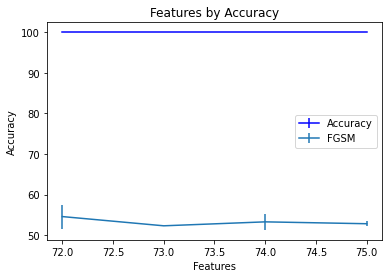

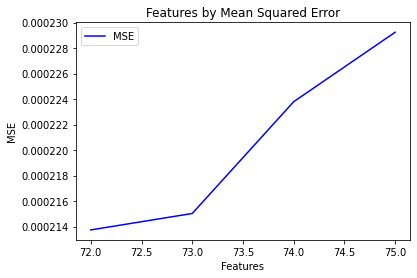

Dropping  Packet Length Mean
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0147 - accuracy: 0.9988
Epoch 2/10
40000/40000 [==============================] - 2s 43us/sample - loss: 7.9902e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.4431e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.0051e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 44us/sample - loss: 4.9529e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.8080e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.8467e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.4762e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 43u

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0153 - accuracy: 0.9985
Epoch 2/10
40000/40000 [==============================] - 2s 44us/sample - loss: 9.4599e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.4849e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 9.6756e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 42us/sample - loss: 4.6510e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.6522e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.7890e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.4193e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2723e-07 -

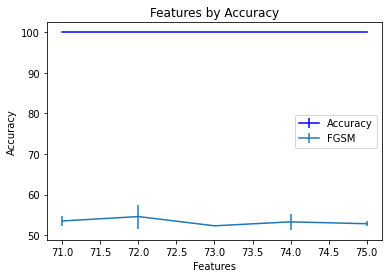

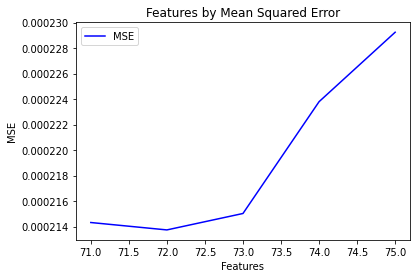

Dropping  Average Packet Size
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 45us/sample - loss: 0.0163 - accuracy: 0.9987
Epoch 2/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.0673e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.9557e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.1733e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 42us/sample - loss: 5.5946e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 42us/sample - loss: 3.1027e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.0223e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.5262e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 43

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0127 - accuracy: 0.9989
Epoch 2/10
40000/40000 [==============================] - 2s 43us/sample - loss: 6.1982e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.5798e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 42us/sample - loss: 6.3926e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 42us/sample - loss: 3.2582e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.0344e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.5343e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.3289e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2343e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 45us/sample - loss: 0.0140 - accuracy: 0.9981
Epoch 2/10
40000/40000 [==============================] - 2s 43us/sample - loss: 9.0180e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.5106e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.0019e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 43us/sample - loss: 4.8157e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.7355e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.8263e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.4378e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2846e-07 -

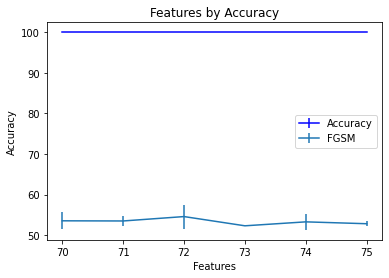

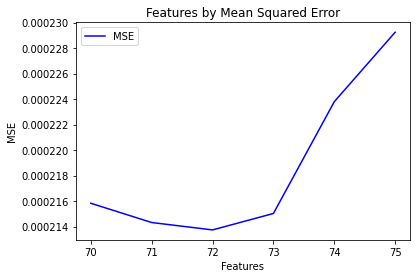

Dropping  Packet Length Std
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0141 - accuracy: 0.9995
Epoch 2/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.0604e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.7712e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.0645e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 43us/sample - loss: 4.9967e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.8125e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.8713e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.4523e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0145 - accuracy: 0.9990
Epoch 2/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.1248e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 3.0345e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 45us/sample - loss: 1.1590e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 43us/sample - loss: 5.2603e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 44us/sample - loss: 2.8333e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.8246e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.4414e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.2839e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0144 - accuracy: 0.9990
Epoch 2/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.0077e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.7570e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.0942e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 44us/sample - loss: 5.2300e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.9171e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.9158e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.4910e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.3058e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 45us/sample - loss: 0.0156 - accuracy: 0.9988
Epoch 2/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.0904e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.9310e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.1507e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 43us/sample - loss: 5.4841e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 44us/sample - loss: 3.0774e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.9986e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.5049e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.3054e-07 -

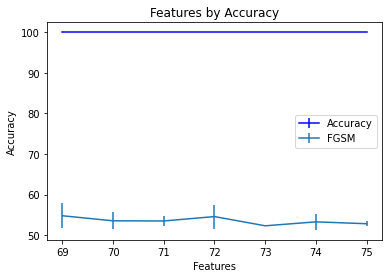

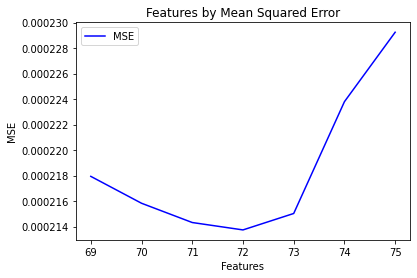

Dropping  Avg Bwd Segment Size
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0145 - accuracy: 0.9977
Epoch 2/10
40000/40000 [==============================] - 2s 44us/sample - loss: 8.3998e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 44us/sample - loss: 2.3786e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 9.4546e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 43us/sample - loss: 4.5659e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.6246e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 46us/sample - loss: 1.8004e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.4404e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 4

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0136 - accuracy: 0.9989
Epoch 2/10
40000/40000 [==============================] - 2s 45us/sample - loss: 1.2803e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 44us/sample - loss: 3.5278e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.3563e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 44us/sample - loss: 6.2147e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 43us/sample - loss: 3.3454e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 45us/sample - loss: 2.0986e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.5593e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.3419e-07 -

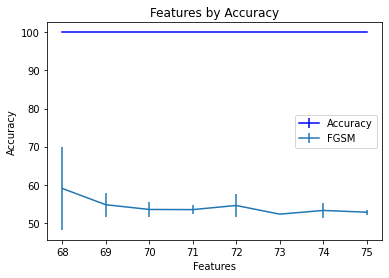

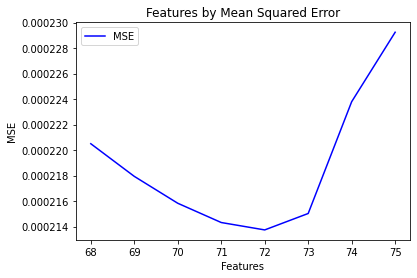

Dropping  min_seg_size_forward
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0156 - accuracy: 0.9983
Epoch 2/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.5033e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 46us/sample - loss: 3.7205e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.3641e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 44us/sample - loss: 6.0871e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 44us/sample - loss: 3.2299e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.0722e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.5575e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 4

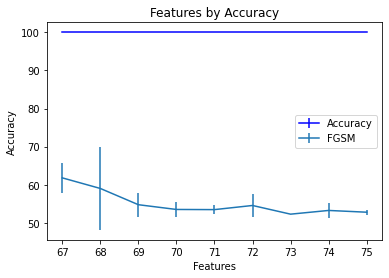

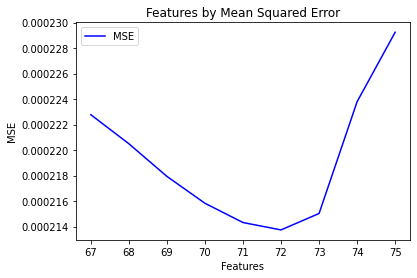

Dropping  Bwd Packet Length Std
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0166 - accuracy: 0.9979
Epoch 2/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.4672e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 44us/sample - loss: 3.6902e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 45us/sample - loss: 1.4002e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 44us/sample - loss: 6.3878e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 44us/sample - loss: 3.4030e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 45us/sample - loss: 2.1675e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.6335e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 

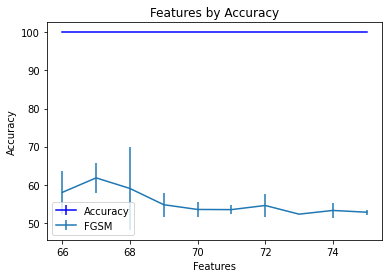

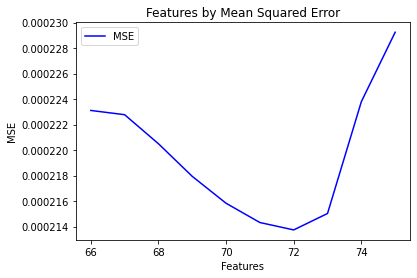

Dropping  Bwd Packet Length Mean
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0160 - accuracy: 0.9974
Epoch 2/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.6104e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 44us/sample - loss: 4.4012e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.6895e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 44us/sample - loss: 7.5567e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 47us/sample - loss: 3.7765e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 46us/sample - loss: 2.2197e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 45us/sample - loss: 1.6402e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s

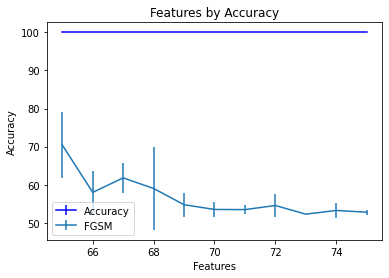

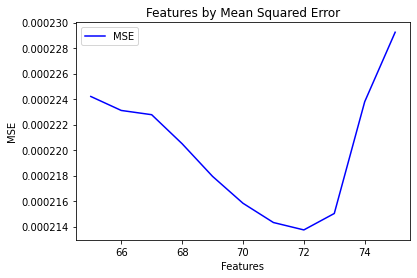

Dropping  Packet Length Variance
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 45us/sample - loss: 0.0147 - accuracy: 0.9984
Epoch 2/10
40000/40000 [==============================] - 2s 45us/sample - loss: 1.3769e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 44us/sample - loss: 3.8280e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.4935e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 44us/sample - loss: 6.7565e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 43us/sample - loss: 3.4338e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.0296e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.4502e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0164 - accuracy: 0.9966
Epoch 2/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.1895e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 45us/sample - loss: 2.5403e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 8.6205e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 44us/sample - loss: 3.7306e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 44us/sample - loss: 2.0518e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.5503e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 45us/sample - loss: 1.3735e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 45us/sample - loss: 1.2849e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0175 - accuracy: 0.9980
Epoch 2/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.1000e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.7684e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.0321e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 43us/sample - loss: 4.6000e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.3878e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 45us/sample - loss: 1.6687e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.4345e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.3202e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 45us/sample - loss: 0.0152 - accuracy: 0.9990
Epoch 2/10
40000/40000 [==============================] - 2s 44us/sample - loss: 9.6778e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 44us/sample - loss: 2.5410e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 9.7561e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 44us/sample - loss: 4.4233e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 44us/sample - loss: 2.3179e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.6077e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.3854e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.2748e-07 -

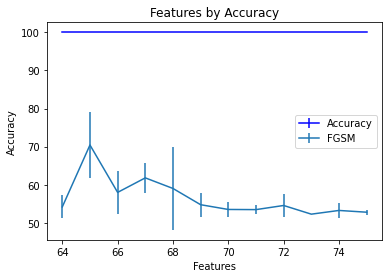

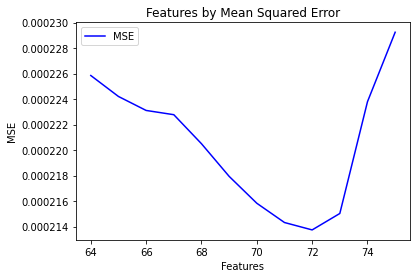

Dropping Fwd IAT Total
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 45us/sample - loss: 0.0140 - accuracy: 0.9992
Epoch 2/10
40000/40000 [==============================] - 2s 45us/sample - loss: 1.0976e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 44us/sample - loss: 3.0039e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.0743e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 44us/sample - loss: 4.4330e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 44us/sample - loss: 2.2392e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.6642e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.4350e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 44us/samp

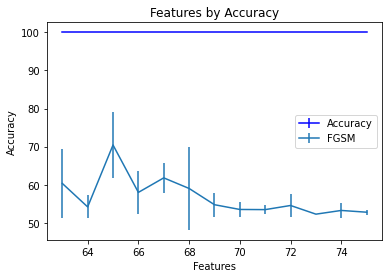

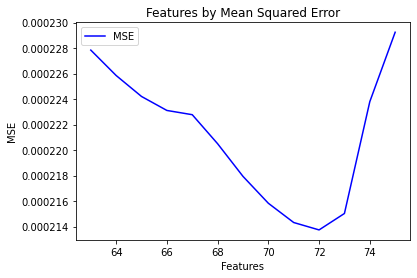

Dropping  URG Flag Count
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0154 - accuracy: 0.9988
Epoch 2/10
40000/40000 [==============================] - 2s 44us/sample - loss: 8.5522e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 44us/sample - loss: 2.4797e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 9.9063e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 44us/sample - loss: 4.7042e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 44us/sample - loss: 2.5454e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.6085e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.3168e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 44us/sa

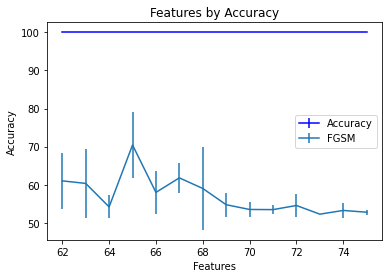

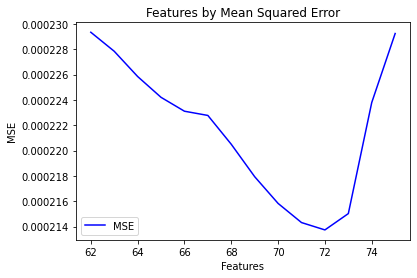

Dropping  Down/Up Ratio
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0171 - accuracy: 0.9985
Epoch 2/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.2803e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 44us/sample - loss: 3.6310e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.3898e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 43us/sample - loss: 6.1701e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 43us/sample - loss: 3.0482e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.7796e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.3804e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 44us/sam

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0136 - accuracy: 1.0000
Epoch 2/10
40000/40000 [==============================] - 2s 43us/sample - loss: 8.9339e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 44us/sample - loss: 2.3202e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 8.8403e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 43us/sample - loss: 4.0131e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.1852e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.4529e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.3147e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.2515e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0160 - accuracy: 0.9995
Epoch 2/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.1735e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 3.1201e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2245e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 42us/sample - loss: 5.5665e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.8837e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.7654e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.3487e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2653e-07 -

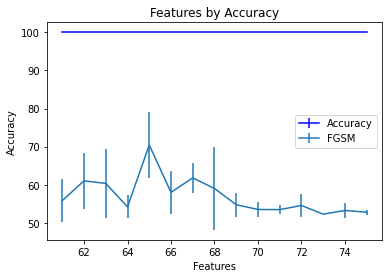

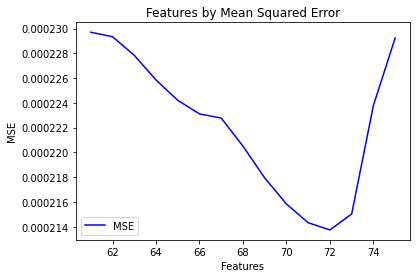

Dropping  Fwd IAT Max
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 42us/sample - loss: 0.0140 - accuracy: 0.9978
Epoch 2/10
40000/40000 [==============================] - 2s 42us/sample - loss: 8.7866e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.4099e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 42us/sample - loss: 9.3529e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 42us/sample - loss: 4.2908e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.3183e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.5094e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2777e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 43us/sampl

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 42us/sample - loss: 0.0178 - accuracy: 0.9961
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.6895e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 42us/sample - loss: 4.6351e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.7823e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 7.9098e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 3.8747e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.1458e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.4758e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3240e-07 -

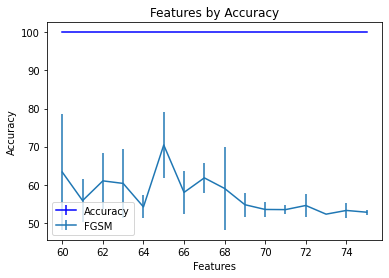

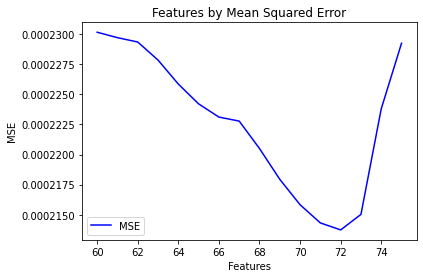

Dropping  Flow IAT Max
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0158 - accuracy: 0.9987
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2870e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 42us/sample - loss: 3.2841e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2200e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 43us/sample - loss: 5.3432e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.6512e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.6010e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.3395e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us/samp

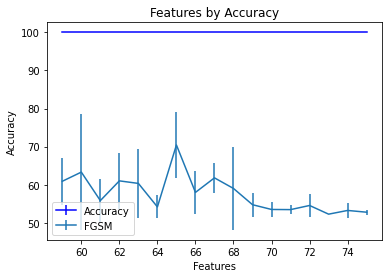

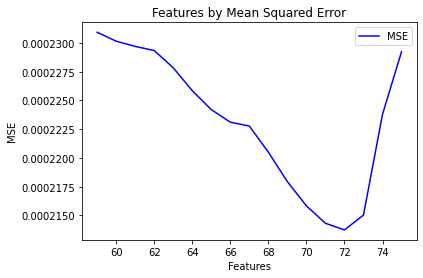

Dropping Init_Win_bytes_forward
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0164 - accuracy: 0.9988
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.7985e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 4.9651e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.9228e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 8.5916e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 4.1835e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.3213e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.5110e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 45us/sample - loss: 0.0175 - accuracy: 0.9979
Epoch 2/10
40000/40000 [==============================] - 2s 44us/sample - loss: 7.5993e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.0292e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 8.2495e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 44us/sample - loss: 3.9418e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 44us/sample - loss: 2.3722e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.7416e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.4659e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3195e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0161 - accuracy: 0.9990
Epoch 2/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.3472e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 42us/sample - loss: 3.6232e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3836e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 6.1420e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 42us/sample - loss: 3.0464e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.8004e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.4290e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3002e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0180 - accuracy: 0.9984
Epoch 2/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.4285e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.9618e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.5537e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 7.0682e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.6138e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.1104e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.4434e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2266e-07 -

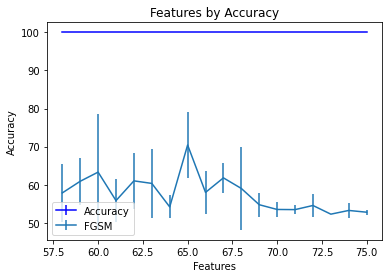

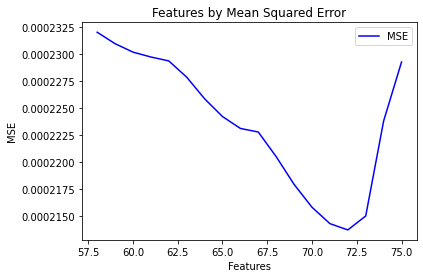

Dropping Idle Mean
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0178 - accuracy: 0.9985
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4363e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 3.8478e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4678e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 6.5079e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.1913e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.8454e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4089e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sample -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0146 - accuracy: 0.9992
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4378e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.9298e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.5068e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 6.7247e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 3.3069e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.9251e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4422e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3071e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0155 - accuracy: 0.9993
Epoch 2/10
40000/40000 [==============================] - 2s 42us/sample - loss: 9.4911e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.6254e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.0252e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 4.7056e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.4974e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.5852e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2628e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2150e-07 -

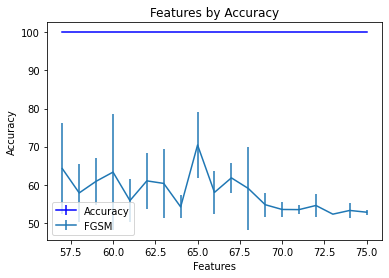

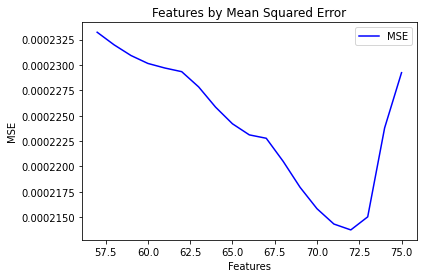

Dropping  Fwd IAT Std
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 40us/sample - loss: 0.0159 - accuracy: 0.9985
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3052e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 39us/sample - loss: 3.4810e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.3274e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 42us/sample - loss: 5.8721e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.9561e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.7766e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.4561e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sampl

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0154 - accuracy: 0.9981
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2404e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 3.2996e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2748e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 5.8043e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.0002e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.8135e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3184e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2386e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0175 - accuracy: 0.9991
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4568e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.5068e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2227e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 39us/sample - loss: 5.0223e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.4518e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.5310e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.3540e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2681e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 40us/sample - loss: 0.0166 - accuracy: 0.9983
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.5585e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 4.1189e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.5542e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 6.8262e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.3112e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.8862e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.4414e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2971e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 40us/sample - loss: 0.0172 - accuracy: 0.9984
Epoch 2/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.9400e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 5.2897e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.0344e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 9.0014e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 4.3675e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.3786e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.5606e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2960e-07 -

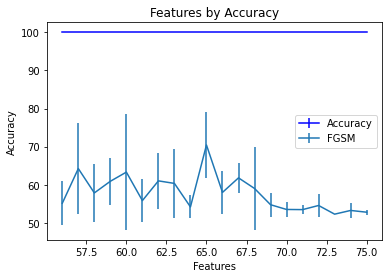

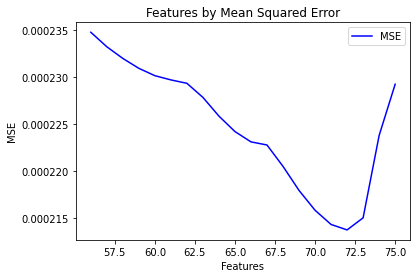

Dropping  Flow IAT Std
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0152 - accuracy: 0.9996
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2982e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.3854e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2751e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 5.6739e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.8622e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.7241e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3925e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/samp

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0158 - accuracy: 0.9999
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 7.7042e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.0300e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 7.8164e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.6156e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.0302e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3913e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2730e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2201e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 42us/sample - loss: 0.0146 - accuracy: 0.9979
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 8.7675e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.3005e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 42us/sample - loss: 8.8111e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 4.0083e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.1043e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4553e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3064e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2399e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0156 - accuracy: 0.9997
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3042e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.4871e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3130e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 5.7842e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.8726e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.7124e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.3976e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2827e-07 -

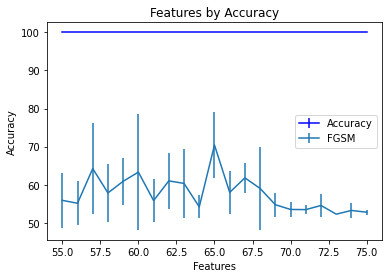

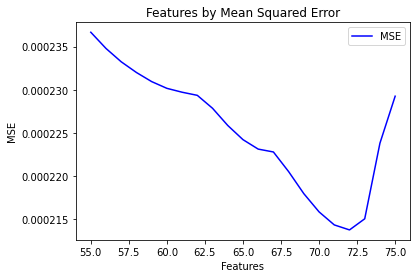

Dropping Bwd IAT Total
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0167 - accuracy: 0.9995
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2945e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.1647e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 7.4837e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 42us/sample - loss: 3.6492e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.1524e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.5628e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.3579e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/samp

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 40us/sample - loss: 0.0162 - accuracy: 0.9996
Epoch 2/10
40000/40000 [==============================] - 2s 38us/sample - loss: 1.7483e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 38us/sample - loss: 3.7521e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 38us/sample - loss: 1.0620e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 39us/sample - loss: 4.1264e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 38us/sample - loss: 2.0886e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.5748e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.3778e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2790e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 40us/sample - loss: 0.0168 - accuracy: 0.9987
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.5056e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 4.2900e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.6984e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 7.8428e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 4.0483e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.3096e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4961e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.2195e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


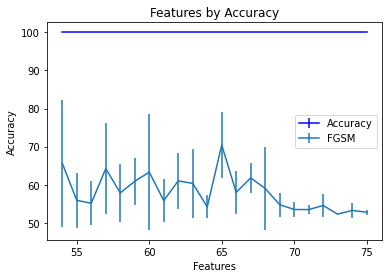

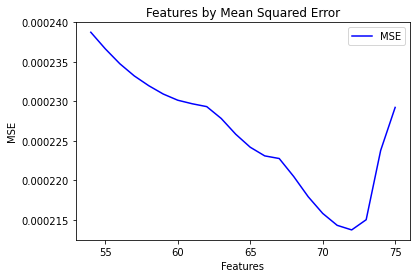

Dropping Fwd PSH Flags
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 40us/sample - loss: 0.0180 - accuracy: 0.9975
Epoch 2/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.3463e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 39us/sample - loss: 3.8987e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.5402e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 39us/sample - loss: 6.9807e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 39us/sample - loss: 3.4669e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.9925e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4894e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/samp

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 40us/sample - loss: 0.0148 - accuracy: 0.9995
Epoch 2/10
40000/40000 [==============================] - 2s 38us/sample - loss: 1.0510e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 39us/sample - loss: 2.5822e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 39us/sample - loss: 9.3993e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 39us/sample - loss: 4.1364e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 38us/sample - loss: 2.1792e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.4241e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.2924e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 38us/sample - loss: 1.2292e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 40us/sample - loss: 0.0175 - accuracy: 0.9964
Epoch 2/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.2805e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 39us/sample - loss: 3.5078e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.3428e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 39us/sample - loss: 5.9962e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 39us/sample - loss: 2.9946e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.7905e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3981e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.2773e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 40us/sample - loss: 0.0186 - accuracy: 0.9981
Epoch 2/10
40000/40000 [==============================] - 2s 55us/sample - loss: 1.3324e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 39us/sample - loss: 2.8792e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 8.8403e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 39us/sample - loss: 3.5962e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.9936e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.5539e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3687e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.2712e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0161 - accuracy: 0.9973
Epoch 2/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.2193e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.2951e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.2680e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 39us/sample - loss: 5.7025e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 39us/sample - loss: 2.8913e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.7584e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3509e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.2564e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


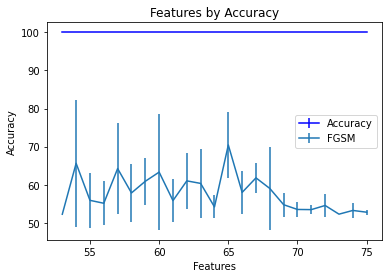

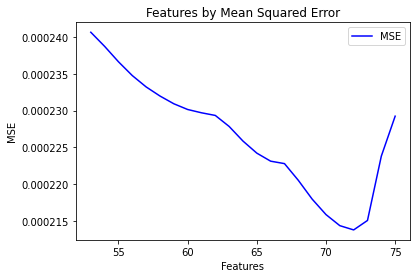

Dropping  SYN Flag Count
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 40us/sample - loss: 0.0161 - accuracy: 0.9993
Epoch 2/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.5803e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 39us/sample - loss: 4.2533e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.6199e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 39us/sample - loss: 7.1107e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 39us/sample - loss: 3.4928e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.9800e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.4235e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 38us/sa

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 39us/sample - loss: 0.0173 - accuracy: 0.9989
Epoch 2/10
40000/40000 [==============================] - 2s 38us/sample - loss: 1.2633e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 38us/sample - loss: 3.3921e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 38us/sample - loss: 1.2970e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 39us/sample - loss: 5.8006e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 38us/sample - loss: 2.9041e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.7337e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 38us/sample - loss: 1.3558e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 38us/sample - loss: 1.2603e-07 -

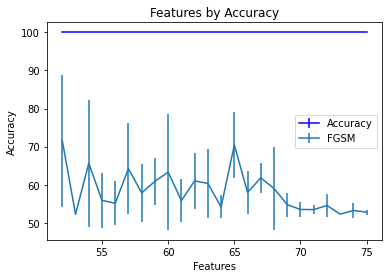

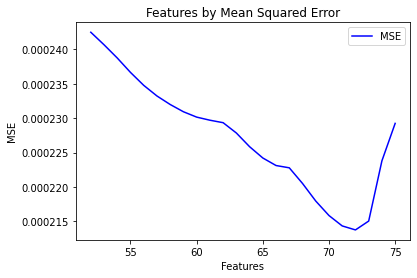

Dropping  Fwd Packet Length Mean
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0176 - accuracy: 0.9984
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4654e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.7667e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3881e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 39us/sample - loss: 5.9924e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 39us/sample - loss: 2.9674e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.7338e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2997e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0162 - accuracy: 0.9987
Epoch 2/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.2232e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.1194e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.1635e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 5.1453e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.6261e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.6328e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.3300e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.2459e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


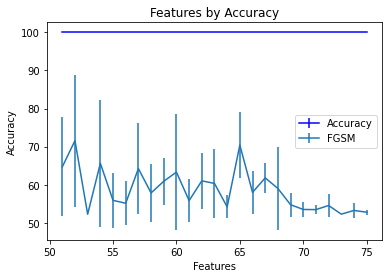

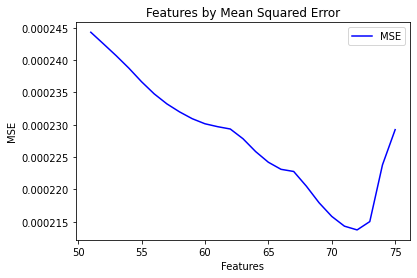

Dropping  Avg Fwd Segment Size
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 40us/sample - loss: 0.0157 - accuracy: 0.9988
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.6696e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 5.1177e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.0509e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 9.3114e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 42us/sample - loss: 4.5464e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.4295e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.6580e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 4

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0141 - accuracy: 0.9994
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 9.6872e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.5288e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 9.5757e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 4.3124e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.2777e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4577e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2995e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2287e-07 -

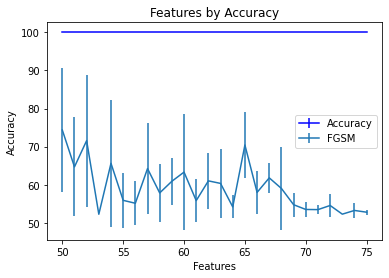

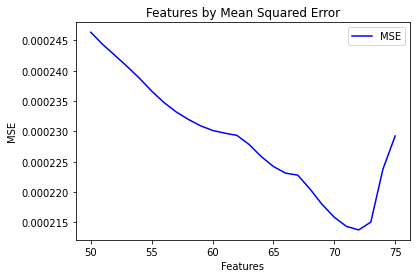

Dropping  Bwd IAT Max
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0164 - accuracy: 0.9991
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4030e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.7756e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4413e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 39us/sample - loss: 6.4194e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 39us/sample - loss: 3.2331e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.9084e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.3289e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sampl

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 42us/sample - loss: 0.0144 - accuracy: 0.9983
Epoch 2/10
40000/40000 [==============================] - 2s 42us/sample - loss: 8.8161e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.0750e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 43us/sample - loss: 7.6601e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 43us/sample - loss: 3.4809e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.9577e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.5383e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3387e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2457e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


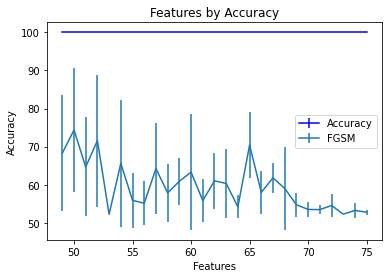

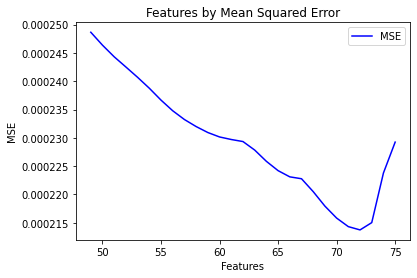

Dropping  Fwd Packet Length Std
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 42us/sample - loss: 0.0157 - accuracy: 0.9992
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3277e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 3.6640e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.4164e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 6.3900e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.2374e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.9260e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3279e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 

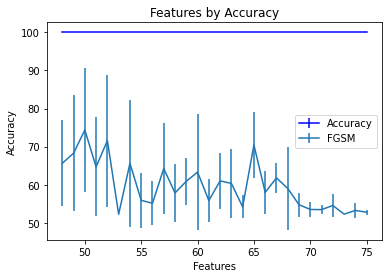

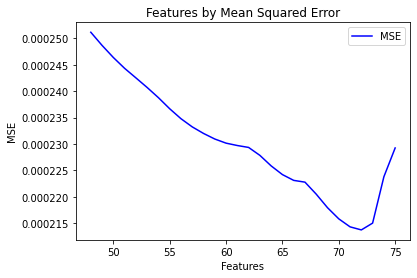

Dropping  Fwd IAT Mean
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 42us/sample - loss: 0.0183 - accuracy: 0.9981
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3392e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 42us/sample - loss: 3.5837e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.3634e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 42us/sample - loss: 6.0629e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.9893e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.7331e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3546e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/samp

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0166 - accuracy: 0.9989
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 6.7325e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.1068e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 4.5445e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.4680e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.7200e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.4313e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2858e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2175e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 42us/sample - loss: 0.0168 - accuracy: 0.9978
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.1414e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.9634e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.1105e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 4.9025e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.5125e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.5635e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3438e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2448e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 40us/sample - loss: 0.0158 - accuracy: 0.9988
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 5.0766e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3015e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 5.0632e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.6134e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.7640e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.4438e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2890e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2175e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0153 - accuracy: 0.9994
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.1114e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.0251e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.1591e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 5.2227e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.6621e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.6436e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3150e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2307e-07 -

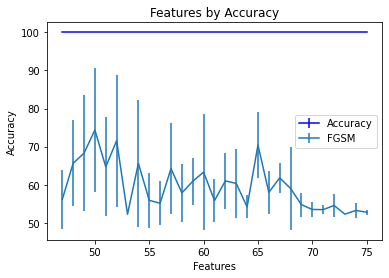

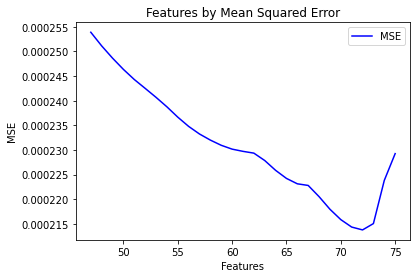

Dropping  Flow IAT Mean
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 46us/sample - loss: 0.0164 - accuracy: 0.9995
Epoch 2/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.5785e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 4.0782e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.5267e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 43us/sample - loss: 6.6788e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 43us/sample - loss: 3.2507e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.8376e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.4639e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us/sam

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0167 - accuracy: 0.9988
Epoch 2/10
40000/40000 [==============================] - 2s 42us/sample - loss: 5.1899e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.1053e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 42us/sample - loss: 4.0881e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.0469e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.4055e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.2702e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.2216e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2033e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0175 - accuracy: 0.9994
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2487e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 3.2607e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2315e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 5.5021e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.8347e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.6876e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3137e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2380e-07 -

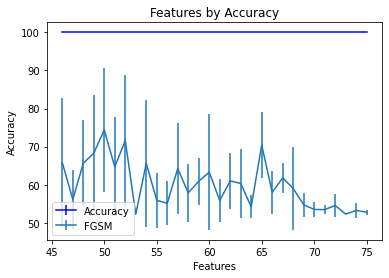

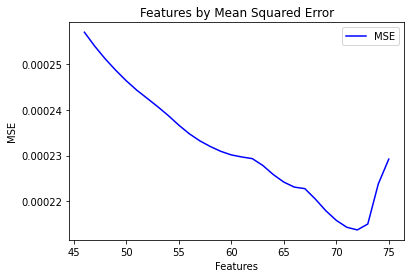

Dropping  Fwd Packet Length Min
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0179 - accuracy: 0.9988
Epoch 2/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.1817e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 42us/sample - loss: 3.5260e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.4008e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 42us/sample - loss: 6.3489e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 42us/sample - loss: 3.1876e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.9209e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.5086e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0164 - accuracy: 0.9995
Epoch 2/10
40000/40000 [==============================] - 2s 42us/sample - loss: 7.9671e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.1107e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 8.2637e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 4.0351e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 47us/sample - loss: 2.3715e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.6993e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.4226e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.2868e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0176 - accuracy: 0.9986
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 5.5344e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.2989e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 4.7921e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.2100e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.4634e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3069e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2329e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2022e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 40us/sample - loss: 0.0172 - accuracy: 0.9959
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 9.9350e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.5633e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 7.6955e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 39us/sample - loss: 2.5320e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.6119e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3764e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2632e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2122e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


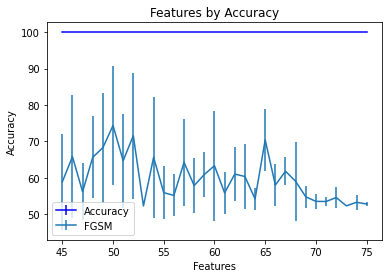

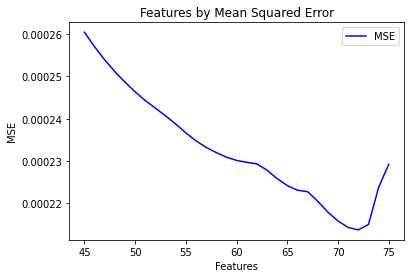

Dropping  Init_Win_bytes_backward
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0185 - accuracy: 0.9982
Epoch 2/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2932e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 42us/sample - loss: 3.4093e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2881e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 5.7363e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.9669e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.7316e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3012e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0169 - accuracy: 0.9989
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 6.7563e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.8633e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 7.7504e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 3.9357e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.3359e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.6849e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4119e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2795e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0164 - accuracy: 0.9991
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4950e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 4.0907e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.5688e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 6.9795e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.4191e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.9332e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.4460e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2839e-07 -

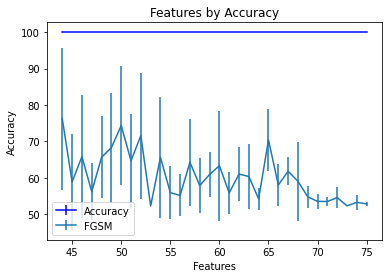

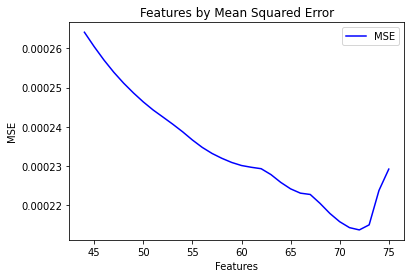

Dropping  Bwd IAT Std
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 44us/sample - loss: 0.0198 - accuracy: 0.9973
Epoch 2/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.5277e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 44us/sample - loss: 4.1969e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 44us/sample - loss: 1.6227e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 43us/sample - loss: 7.2870e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 3.7138e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.1323e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3974e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us/sampl

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0163 - accuracy: 0.9995
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.6860e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 4.6108e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.7947e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 8.0328e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.8910e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.1190e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.5325e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.3460e-07 -

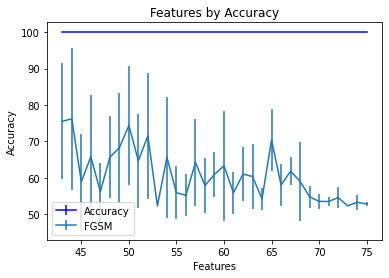

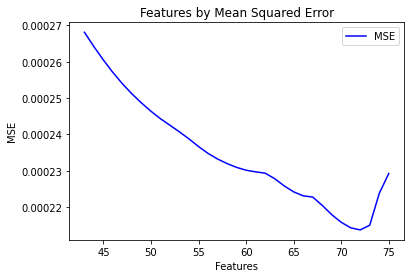

Dropping FIN Flag Count
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0170 - accuracy: 0.9983
Epoch 2/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.3329e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.4797e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3251e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 6.0223e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.1385e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.8497e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2489e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sam

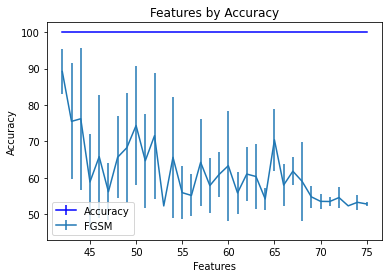

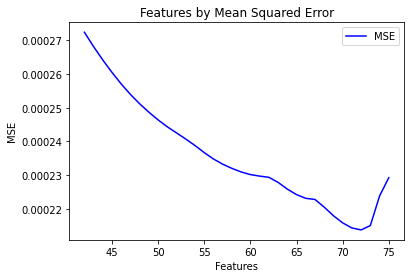

Dropping  Fwd IAT Min
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 42us/sample - loss: 0.0171 - accuracy: 0.9995
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.1332e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.5619e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 8.1915e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.3383e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.7784e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4154e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2735e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 39us/sampl

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0149 - accuracy: 0.9990
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.8058e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 5.0265e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.9452e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 8.6633e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 4.2475e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.3451e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4947e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2467e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0177 - accuracy: 0.9965
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 8.4694e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 39us/sample - loss: 3.2811e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4468e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 6.9008e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 3.5241e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.9760e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4213e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2893e-07 -

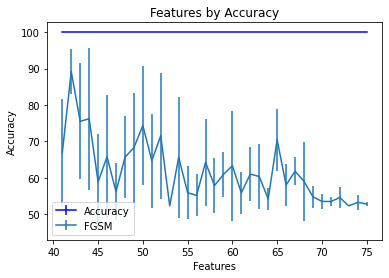

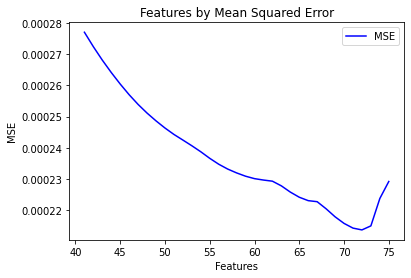

Dropping  Bwd IAT Min
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 40us/sample - loss: 0.0163 - accuracy: 0.9984
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.5979e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 4.5464e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.8429e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 8.3982e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 4.1467e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.2182e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4865e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sampl

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0176 - accuracy: 0.9995
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.6866e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 4.6408e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.7898e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 42us/sample - loss: 7.9622e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 3.8475e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.0900e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.5016e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3271e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 42us/sample - loss: 0.0168 - accuracy: 0.9996
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.4715e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 3.8812e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.4593e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 42us/sample - loss: 6.4005e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 42us/sample - loss: 3.1076e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.7418e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3851e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2626e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0128 - accuracy: 0.9998
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 8.5456e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.2863e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 8.6382e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 42us/sample - loss: 3.9044e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.1332e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.3891e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2643e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2164e-07 -

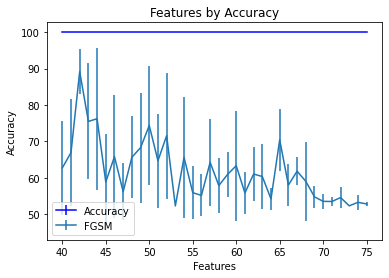

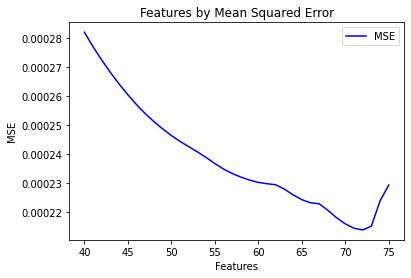

Dropping  Subflow Bwd Bytes
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0170 - accuracy: 0.9991
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 7.3374e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.9570e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 7.4571e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 3.5982e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.1320e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.5746e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.3548e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us

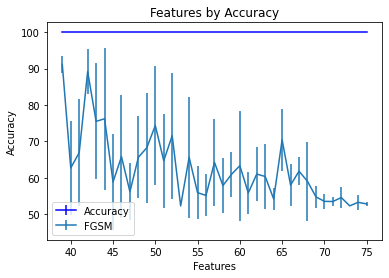

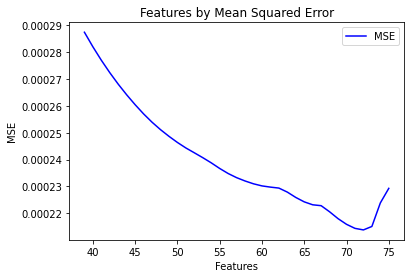

Dropping  Fwd Header Length
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 42us/sample - loss: 0.0152 - accuracy: 0.9983
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3556e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 42us/sample - loss: 3.5335e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.1216e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 4.3628e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.1124e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4575e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2845e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0144 - accuracy: 0.9994
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.0905e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.7616e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.0160e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 4.4673e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.3325e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.4477e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2699e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2096e-07 -

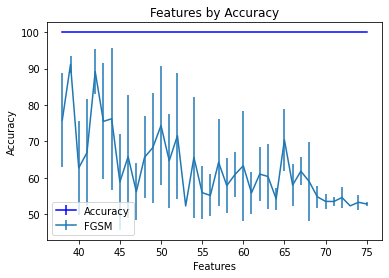

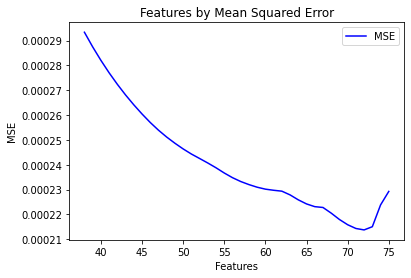

Dropping  Fwd Header Length.1
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0152 - accuracy: 0.9991
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.0707e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.8973e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.0717e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 4.4495e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.1099e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4992e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3175e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 42

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 42us/sample - loss: 0.0187 - accuracy: 0.9987
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.1446e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 3.1480e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2097e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 5.4323e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 39us/sample - loss: 2.7790e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.6768e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.3174e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2307e-07 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0158 - accuracy: 0.9996
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.5448e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.5350e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2723e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 5.6670e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.9544e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.7671e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2681e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2158e-07 -

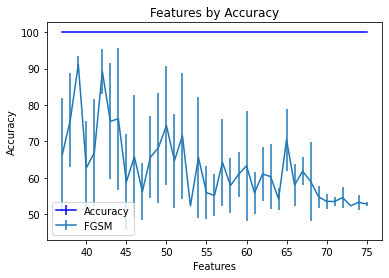

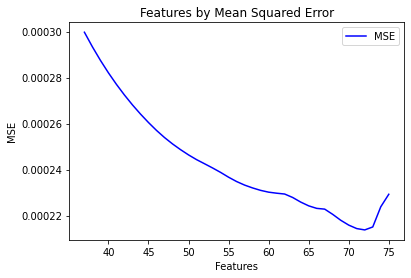

Dropping  Active Min
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0180 - accuracy: 0.9977
Epoch 2/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.6254e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 42us/sample - loss: 4.4418e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.7085e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 44us/sample - loss: 7.5892e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 44us/sample - loss: 3.7262e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 43us/sample - loss: 2.1036e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 43us/sample - loss: 1.4006e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 44us/sample

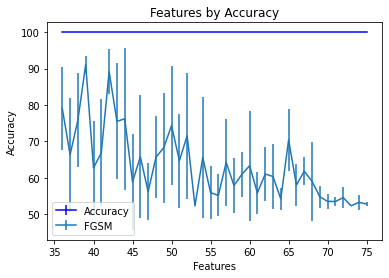

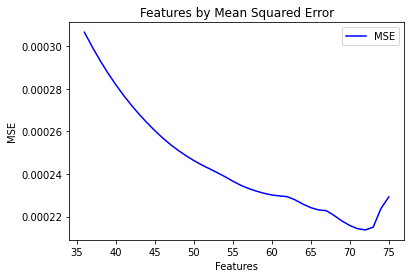

Dropping  act_data_pkt_fwd
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0183 - accuracy: 0.9984
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2465e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.5042e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3598e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 6.1100e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.1461e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.8422e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3288e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/

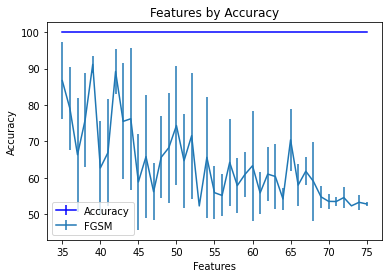

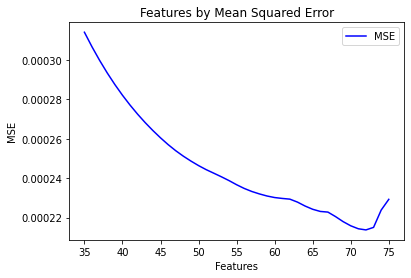

Dropping Active Mean
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 40us/sample - loss: 0.0159 - accuracy: 0.9989
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.4782e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.8187e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3229e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 4.9621e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.3095e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.6440e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3859e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sample

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 42us/sample - loss: 0.0180 - accuracy: 0.9983
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 5.8068e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.5752e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 6.1914e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 3.1099e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.9478e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.5255e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3300e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2340e-07 -

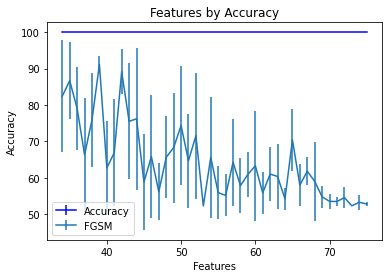

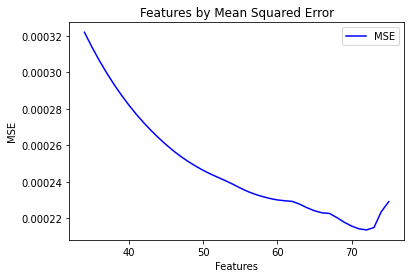

Dropping Subflow Fwd Packets
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0178 - accuracy: 0.9987
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.0510e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.2834e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 6.5435e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.8802e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.8197e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.4500e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2914e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41u

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 42us/sample - loss: 0.0164 - accuracy: 0.9987
Epoch 2/10
40000/40000 [==============================] - 2s 42us/sample - loss: 8.1936e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.2068e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 8.5070e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.9320e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.1579e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.3823e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2425e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2007e-07 -

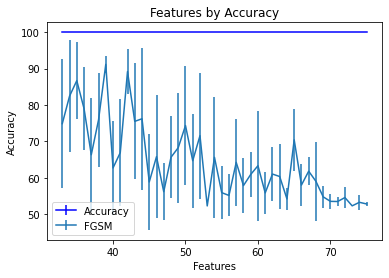

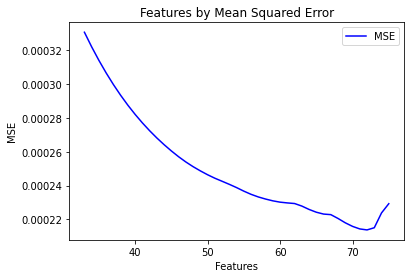

Dropping  Active Max
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0153 - accuracy: 0.9989
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2216e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 3.3755e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2975e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 5.8150e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.9930e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.7608e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2572e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sample

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


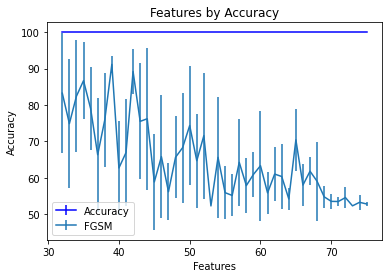

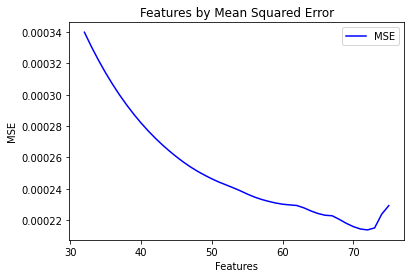

Dropping  Bwd Header Length
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 42us/sample - loss: 0.0210 - accuracy: 0.9965
Epoch 2/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.5702e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 3.4754e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.0557e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 4.1056e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.0223e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.5387e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3379e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us

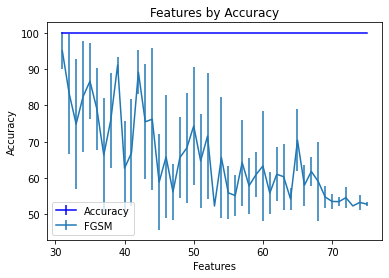

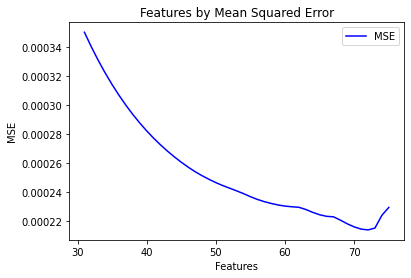

Dropping  Subflow Bwd Packets
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 42us/sample - loss: 0.0199 - accuracy: 0.9971
Epoch 2/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.4482e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 41us/sample - loss: 3.5785e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 42us/sample - loss: 1.2913e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 5.6283e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 42us/sample - loss: 2.9080e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.6818e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2394e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 41

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


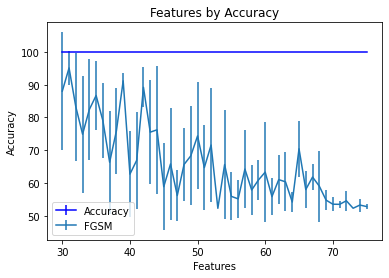

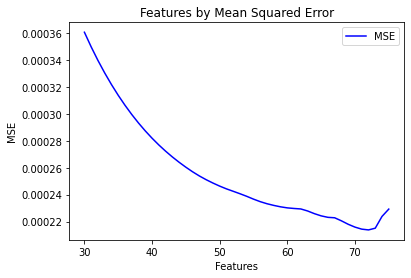

Dropping Fwd Packets/s
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0173 - accuracy: 0.9993
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.1067e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.5277e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4522e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 41us/sample - loss: 6.7319e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.4639e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.0442e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.3466e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/samp

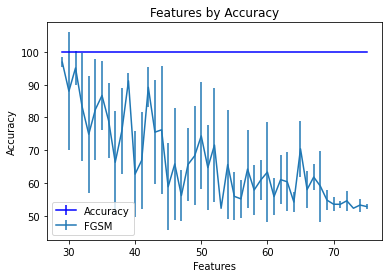

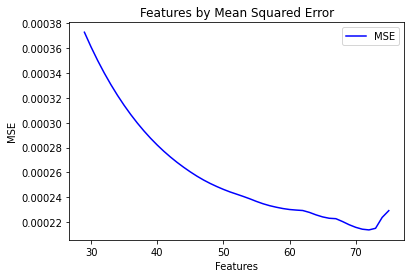

Dropping  RST Flag Count
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0135 - accuracy: 0.9997
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.4346e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.6341e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3550e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 6.0543e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.1490e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.8886e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2571e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sa

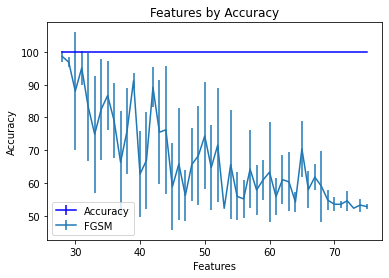

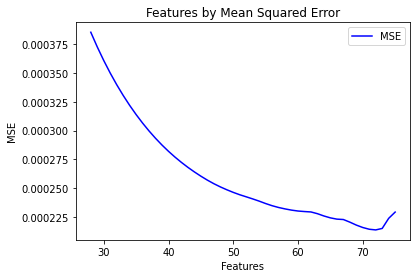

Dropping  ECE Flag Count
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0158 - accuracy: 0.9990
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 8.9453e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 2.6309e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.0499e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 39us/sample - loss: 4.8639e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 41us/sample - loss: 2.5581e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.5780e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3224e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/sa

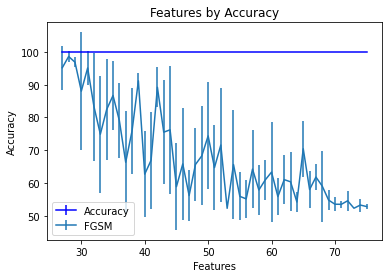

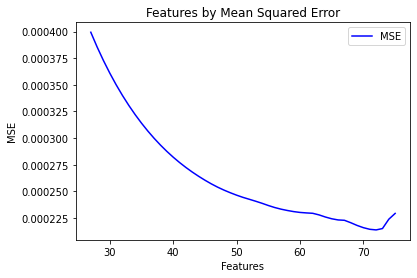

Dropping  Flow IAT Min
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0162 - accuracy: 0.9989
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2261e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.3447e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2896e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 5.8105e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.0186e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.7738e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.2752e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us/samp

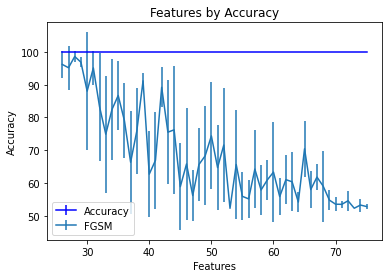

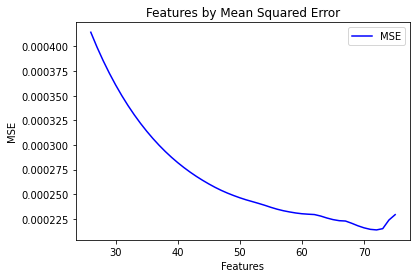

Dropping  Active Std
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 40us/sample - loss: 0.0156 - accuracy: 0.9998
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 7.2428e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.7880e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 6.7250e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.1439e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.7689e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.4493e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.3002e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 39us/sample

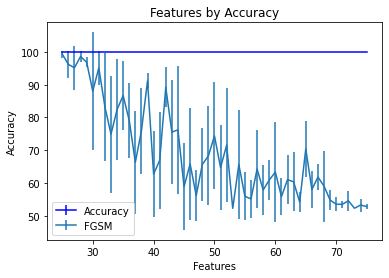

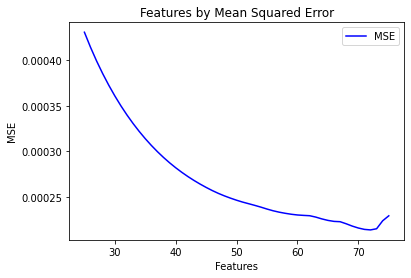

Dropping  Bwd Packets/s
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 39us/sample - loss: 0.0171 - accuracy: 0.9990
Epoch 2/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.3146e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 39us/sample - loss: 3.4256e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.2810e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 39us/sample - loss: 5.6039e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 39us/sample - loss: 2.7892e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.6532e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.2936e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 39us/sam

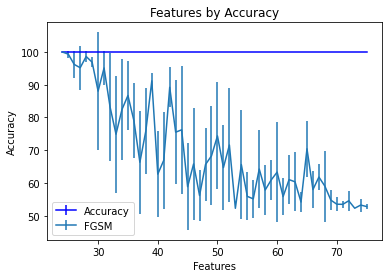

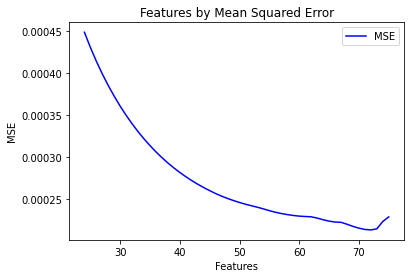

Dropping  Bwd IAT Mean
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 40us/sample - loss: 0.0175 - accuracy: 0.9990
Epoch 2/10
40000/40000 [==============================] - 2s 39us/sample - loss: 8.8100e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 39us/sample - loss: 2.3878e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 39us/sample - loss: 9.1849e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 39us/sample - loss: 4.3862e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 38us/sample - loss: 2.4880e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 38us/sample - loss: 1.7251e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 38us/sample - loss: 1.4122e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 39us/samp

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0156 - accuracy: 0.9995
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 7.7290e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.9312e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 40us/sample - loss: 7.4271e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 3.5752e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.9921e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.3087e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.2065e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.2005e-07 -

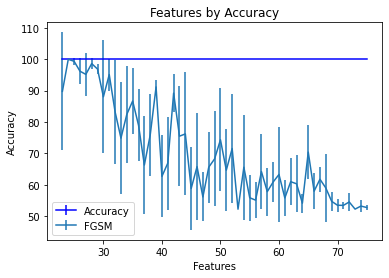

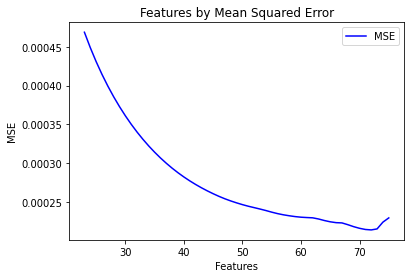

Dropping  Subflow Fwd Bytes
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 39us/sample - loss: 0.0163 - accuracy: 0.9992
Epoch 2/10
40000/40000 [==============================] - 2s 39us/sample - loss: 8.9899e-06 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 39us/sample - loss: 2.1011e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 39us/sample - loss: 7.8972e-07 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 39us/sample - loss: 3.6135e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 38us/sample - loss: 2.2222e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 38us/sample - loss: 1.6740e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 38us/sample - loss: 1.4037e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 38us

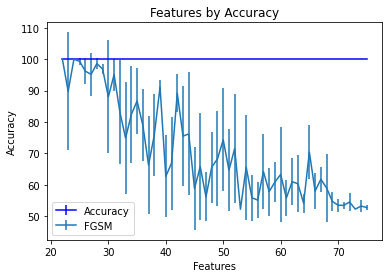

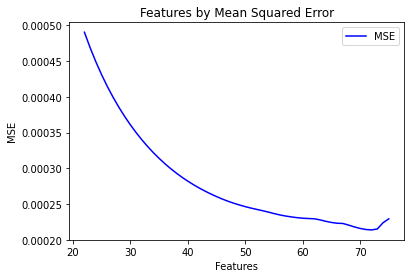

Dropping  Min Packet Length
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 41us/sample - loss: 0.0153 - accuracy: 0.9991
Epoch 2/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.6292e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 40us/sample - loss: 4.4509e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 41us/sample - loss: 1.7171e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 40us/sample - loss: 7.6464e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 39us/sample - loss: 3.6809e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.9359e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.3311e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 40us

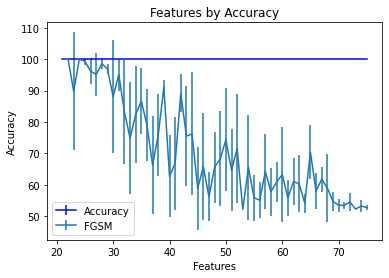

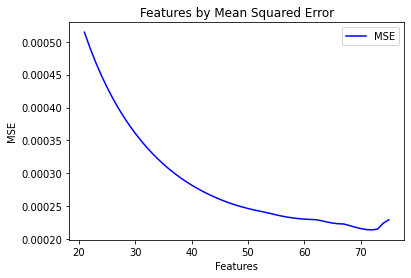

Dropping  Bwd Packet Length Min
Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 42us/sample - loss: 0.0208 - accuracy: 0.9978
Epoch 2/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.1220e-05 - accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 2s 39us/sample - loss: 2.7829e-06 - accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.0193e-06 - accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 2s 39us/sample - loss: 4.4431e-07 - accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 2s 39us/sample - loss: 2.1749e-07 - accuracy: 1.0000
Epoch 7/10
40000/40000 [==============================] - 2s 39us/sample - loss: 1.3230e-07 - accuracy: 1.0000
Epoch 8/10
40000/40000 [==============================] - 2s 40us/sample - loss: 1.1921e-07 - accuracy: 1.0000
Epoch 9/10
40000/40000 [==============================] - 2s 

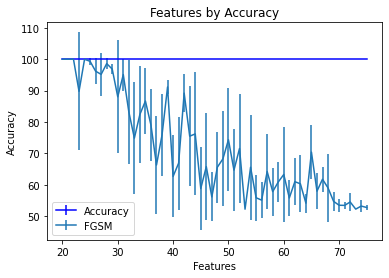

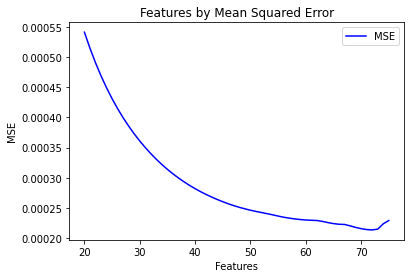

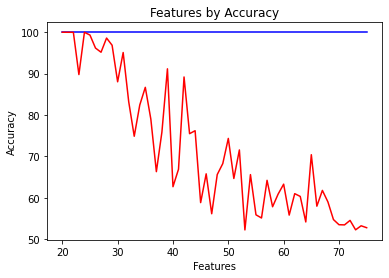

No handles with labels found to put in legend.


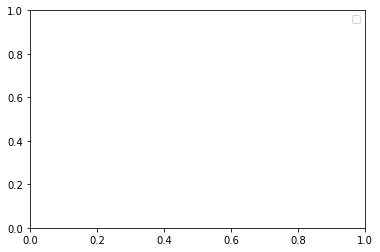

ValueError: ignored

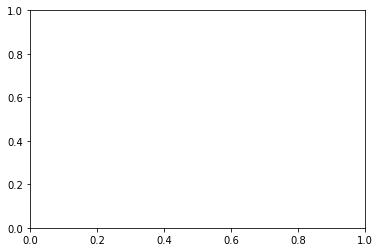

In [ ]:
# Import the attack
from cleverhans.future.tf2.attacks import fast_gradient_method

features = []
accuracys = []
mseerrors = []
minmseerrors = []
test_accuracys = []

mean_accuracy = []
std_accuracy = []

mean_fgsm_accuracy = []
std_fgsm_accuracy = []

best_case_fgsm = []
worst_case_fgsm = []

mean_mses = []
std_mses = []

#features_sorted_biggest_difference = [' PSH Flag Count', ' ACK Flag Count', 'Bwd Packet Length Max', ' Max Packet Length', ' Packet Length Mean', ' Average Packet Size', ' Packet Length Std', ' Avg Bwd Segment Size', ' Flow Packets/s', ' min_seg_size_forward', ' Bwd Packet Length Std', ' Bwd Packet Length Mean', ' Packet Length Variance', 'Fwd IAT Total', ' URG Flag Count', ' Down/Up Ratio', ' Fwd IAT Max', ' Flow IAT Max', 'Init_Win_bytes_forward', 'Idle Mean', ' Fwd IAT Std', ' Flow IAT Std', 'Bwd IAT Total', 'Fwd PSH Flags', ' SYN Flag Count', ' Fwd Packet Length Mean', ' Avg Fwd Segment Size', ' Bwd IAT Max', ' Fwd Packet Length Std', ' Fwd IAT Mean', ' Flow IAT Mean', ' Fwd Packet Length Min', ' Init_Win_bytes_backward', ' Bwd IAT Std', 'Flow Bytes/s', 'FIN Flag Count', ' Fwd IAT Min', ' Bwd IAT Min', ' Subflow Bwd Bytes', ' Fwd Header Length', ' Fwd Header Length.1', ' Active Min', ' act_data_pkt_fwd', 'Active Mean', 'Subflow Fwd Packets', ' Active Max', ' Bwd Header Length', ' Subflow Bwd Packets', 'Fwd Packets/s', ' RST Flag Count', ' ECE Flag Count', ' Flow IAT Min', ' Active Std', ' Bwd Packets/s', ' Bwd IAT Mean', ' Subflow Fwd Bytes', ' Min Packet Length', ' Bwd Packet Length Min']

#features_sorted_biggest_difference = [' PSH Flag Count', ' ACK Flag Count', 'Bwd Packet Length Max', ' Max Packet Length', ' Packet Length Mean', ' Average Packet Size', ' Packet Length Std', ' Avg Bwd Segment Size', ' min_seg_size_forward', ' Bwd Packet Length Std', ' Bwd Packet Length Mean', ' Packet Length Variance', 'Fwd IAT Total', ' URG Flag Count', ' Down/Up Ratio', ' Fwd IAT Max', ' Flow IAT Max', 'Init_Win_bytes_forward', 'Idle Mean', ' Fwd IAT Std', ' Flow IAT Std', 'Bwd IAT Total', 'Fwd PSH Flags', ' SYN Flag Count', ' Fwd Packet Length Mean', ' Avg Fwd Segment Size', ' Bwd IAT Max', ' Fwd Packet Length Std', ' Fwd IAT Mean', ' Flow IAT Mean', ' Fwd Packet Length Min', ' Init_Win_bytes_backward', ' Bwd IAT Std', 'Flow Bytes/s', 'FIN Flag Count', ' Fwd IAT Min', ' Bwd IAT Min', ' Subflow Bwd Bytes', ' Fwd Header Length', ' Fwd Header Length.1', ' Active Min', ' act_data_pkt_fwd', 'Active Mean', 'Subflow Fwd Packets', ' Active Max', ' Bwd Header Length', ' Subflow Bwd Packets', 'Fwd Packets/s', ' RST Flag Count', ' ECE Flag Count', ' Flow IAT Min', ' Active Std', ' Bwd Packets/s', ' Bwd IAT Mean', ' Subflow Fwd Bytes', ' Min Packet Length', ' Bwd Packet Length Min']

features_sorted_biggest_difference = [' PSH Flag Count', ' ACK Flag Count', 'Bwd Packet Length Max', ' Max Packet Length', ' Packet Length Mean', ' Average Packet Size', ' Packet Length Std', ' Avg Bwd Segment Size', ' min_seg_size_forward', ' Bwd Packet Length Std', ' Bwd Packet Length Mean', ' Packet Length Variance', 'Fwd IAT Total', ' URG Flag Count', ' Down/Up Ratio', ' Fwd IAT Max', ' Flow IAT Max', 'Init_Win_bytes_forward', 'Idle Mean', ' Fwd IAT Std', ' Flow IAT Std', 'Bwd IAT Total', 'Fwd PSH Flags', ' SYN Flag Count', ' Fwd Packet Length Mean', ' Avg Fwd Segment Size', ' Bwd IAT Max', ' Fwd Packet Length Std', ' Fwd IAT Mean', ' Flow IAT Mean', ' Fwd Packet Length Min', ' Init_Win_bytes_backward', ' Bwd IAT Std', 'FIN Flag Count', ' Fwd IAT Min', ' Bwd IAT Min', ' Subflow Bwd Bytes', ' Fwd Header Length', ' Fwd Header Length.1', ' Active Min', ' act_data_pkt_fwd', 'Active Mean', 'Subflow Fwd Packets', ' Active Max', ' Bwd Header Length', ' Subflow Bwd Packets', 'Fwd Packets/s', ' RST Flag Count', ' ECE Flag Count', ' Flow IAT Min', ' Active Std', ' Bwd Packets/s', ' Bwd IAT Mean', ' Subflow Fwd Bytes', ' Min Packet Length', ' Bwd Packet Length Min']

num_features = 76

for feature_to_drop in features_sorted_biggest_difference:
  print("Dropping {}".format(feature_to_drop))
  dataset = dataset.drop(columns=feature_to_drop)
  X = dataset
  num_features = num_features -1

  # Performing scale data
  scaler = MinMaxScaler().fit(X)
  X_scaled = np.array(scaler.transform(X))

  
  #X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_class, test_size = 0.7, shuffle=True, random_state = 42, stratify=Y_class)

  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  cvscores = []
  fgsmcvscores = []
  for train, test in kfold.split(X_scaled, Y_class):
    # create model

    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=[X_scaled[train].shape[1]]),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(len(np.unique(Y_class))),
        tf.keras.layers.Activation(tf.nn.softmax)
    ])






    model.compile(optimizer='adam',
                  #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  loss= 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])

  
    model.fit(X_scaled[train], Y_class[train], epochs=10)
  
    #test_loss, test_acc = model.evaluate(X_test, Y_test)
    scores = model.evaluate(X_scaled[test], Y_class[test])
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    #print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
  
    print("======\n")
    print('Number of features\t  Test accuracy:')
    #print("{}\t{}".format(num_features, test_acc))
    #features.append(num_features+1)
    #accuracys.append(test_acc)
    #print("{}\t{}".format(features,accuracys))

    #The attack requires the model to ouput the logits
    logits_model = tf.keras.Model(model.input,model.layers[-1].output)

    # Batch run on all test data

    CLASS_TO_CHANGE = 1 # 1 will make all true cases appear as false

    X_adv = np.zeros(X_scaled[test].shape)

    print (X_scaled[test].shape)


    for i in range(X_scaled[test].shape[0]):
      current_class = Y_class[test][i]
      #print("Class:", current_class)
      if current_class == CLASS_TO_CHANGE:
          example_vals = X_scaled[test][i, :]
          example_labels = Y_class[test][i]
          example_vals = tf.convert_to_tensor(example_vals.reshape((1, num_features+1)))
          example_labels = np.reshape(example_labels, (1,)).astype('int64')
          epsilon = 0.1
          adv_example_untargeted_label = fast_gradient_method(logits_model, example_vals, epsilon, np.inf, targeted=False)
          adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)
    
          X_adv[i,:] = adv_example_untargeted_label
          #X_test[i,:] = adv_example_untargeted_label
          #print (example_labels, "--->", np.argmax(adv_example_untargeted_label_pred))
          #print(X_test[i,:])
          #outputfile= pd.DataFrame(X_test[i,:])
          #outputfile.to_csv('mount/My Drive/Colab Notebooks/network_data/adversarial.csv')

    print("This is where the Adversarial Example is")
    print(X_adv)
    for i in range(X_adv.shape[0]):
        #print(X_test[i])
        #print(".")
        #print(example_vals) 
        pass

    #outputfile = pd.DataFrame(X_test)
    #outputfile.to_csv('mount/My Drive/Colab Notebooks/network_data/adversarial.csv')
    #sys.exit()

    #find overall difference
    error = (X_scaled[test] - X_adv)
    #print (error)
    #find MeanSquaredError
    mse = tf.reduce_mean(tf.square(error, name="mse"))
    mseerrors.append(mse)

    mean_mses.append(np.mean(mseerrors))
    std_mses.append(np.std(mseerrors))
  


    fgsmscores = model.evaluate(X_adv, Y_class[test])
    print("%s: %.2f%%" % (model.metrics_names[1], fgsmscores[1]*100))
    fgsmcvscores.append(fgsmscores[1] * 100)
    #print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    #test_loss, test_acc = model.evaluate(X_test, Y_test)
    #print('FGSM accuracy:', test_acc)
    #test_accuracys.append(test_acc)
    #print("{}\n{}\n{}".format(features,accuracys,test_accuracys))

    from sklearn.metrics import classification_report

    y_pred = model.predict(X_adv, batch_size=64, verbose=1)
    y_pred_bool = np.argmax(y_pred, axis=1)

    print(classification_report(Y_class[test], y_pred_bool))

  features.append(num_features)
  mean_accuracy.append(np.mean(cvscores))
  std_accuracy.append(np.std(cvscores))

  mean_fgsm_accuracy.append(np.mean(fgsmcvscores))
  std_fgsm_accuracy.append(np.std(fgsmcvscores))
  best_case_fgsm.append(np.mean(fgsmcvscores) + np.std(fgsmcvscores))
  worst_case_fgsm.append(np.mean(fgsmcvscores) - np.std(fgsmcvscores))


  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
  print("%.2f%% (+/- %.2f%%)" % (np.mean(fgsmcvscores), np.std(fgsmcvscores)))
    
  print("Results_Table") 

  results_table = np.column_stack([features, mean_accuracy, std_accuracy, mean_fgsm_accuracy, std_fgsm_accuracy, best_case_fgsm, worst_case_fgsm])

  print(results_table)
  np.savetxt("mount/My Drive/Colab Notebooks/CICIDS2017/results_table.csv", results_table, delimiter=",")
  
  #plt.plot(features, mean_accuracy, linestyle='solid', c='b', label='Accuracy')
  plt.errorbar(features, mean_accuracy, yerr=std_accuracy, linestyle='solid', c='b', label='Accuracy')
  #plt.plot(features, mean_fgsm_accuracy, linestyle='solid', c='r', label='Accuracy under attack')
  plt.errorbar(features, mean_fgsm_accuracy, yerr=std_fgsm_accuracy, xlolims=True, label='FGSM')
  plt.xlabel('Features')
  plt.ylabel('Accuracy')
  plt.title('Features by Accuracy')
  plt.legend(loc='best')
  plt.show()

  #Fudge the MSEs before printing 
  #Take only every fifth 

  mse_fifth = []

  for i in range(0,len(mean_mses),5):
    mse_fifth.append(mean_mses[i])
  

  mse_for_plot = []

  for i in range(0, len(mse_fifth)):
    mse_for_plot.append(mse_fifth[i]/features[i])
    


  plt.plot(features, mse_for_plot, linestyle='solid', c='b', label='MSE')
  plt.legend(loc='best')
  plt.xlabel('Features')
  plt.ylabel('MSE')
  plt.title('Features by Mean Squared Error')
  plt.show()


plt.plot(features, mean_accuracy, linestyle='solid', c='b', label='Accuracy')
plt.plot(features, mean_fgsm_accuracy, linestyle='solid', c='r', label='FGSM')

plt.xlabel('Features')
#xticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
#plt.xticks(xticks,xticks)
plt.ylabel('Accuracy')
plt.title('Features by Accuracy')
plt.show()


#plt.scatter(mserrors[1], mserrors[1])

#plt.scatter(X[:9999, 0], X[:9999, 1], color='blue', alpha=0.4, label='Original Data')



#plt.scatter(Xadv[:9999, 0], Xadv[:9999, 1], color='green', alpha=0.4, label='Adversarial Examples, Epsilon = 0.2')
#plt.scatter(Xadv2[:9999, 0], Xadv2[:9999, 1], color='purple', alpha=0.4, label='Adversarial Examples, Epsilon = 0.5')
#plt.scatter(X[10000:, 0], X[10000:, 1], color='red', alpha=0.4, label='Original Data')
#plt.scatter(Xadv[10000:, 0], Xadv[10000:, 1], color='orange', alpha=0.4, label='Adversarial Examples, Epsilon = 0.2')
#plt.scatter(Xadv2[10000:, 0], Xadv2[10000:, 1], color='yellow', alpha=0.4, label='Adversarial Examples, Epsilon = 0.5')
plt.legend(loc='best')
plt.show()


plt.plot(features, mseerrors, linestyle='solid', c='b', label='MSE')
plt.legend(loc='best')
plt.xlabel('Features')
plt.ylabel('MSE')
plt.title('Features by Mean Squared Error')

plt.show()

In [ ]:
plt.plot(features, mean_accuracy, linestyle='solid', c='b', label='Accuracy')
plt.plot(features, mean_fgsm_accuracy, linestyle='solid', c='r', label='Accuracy under attack')
plt.errorbar(features, mean_fgsm_accuracy, yerr=std_fgsm_accuracy, xlolims=True, label='xlolims=True')
plt.xlabel('Features')
plt.ylabel('Accuracy')
plt.title('Features by Accuracy')
plt.legend(loc='best')
plt.show()


In [ ]:
#results_table = np.column_stack([features, mean_accuracy, std_accuracy, mean_fgsm_accuracy, std_fgsm_accuracy, best_case_fgsm, worst_case_fgsm])

print(results_table)

#np.savetxt("mount/My Drive/Colab Notebooks/CICIDS2017/results_table.csv", results_table, delimiter=",")

plt.scatter(features, mean_accuracy, linestyle='solid', c='b', label='Accuracy')
plt.scatter(features, mean_fgsm_accuracy, linestyle='solid', c='r', label='Accuracy under attack')
plt.xlabel('Features')
#xticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
#plt.xticks(xticks,xticks)
plt.ylabel('Accuracy')
plt.title('Features by Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
# Import the attack
from cleverhans.future.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

In [ ]:
# Get a random test case
ra = np.random.randint(X_test.shape[0])
print ("Index:",ra)
example_vals = X_test[ra, :]
example_labels = Y_test[ra]
#example_labels = Y_attack[ra]

example_vals = tf.convert_to_tensor(example_vals.reshape((1, 77)))
example_labels = np.reshape(example_labels, (1,)).astype('int64')

print ("Values:",example_vals)
print ("Label:", example_labels)

In [ ]:
# Non-Targeted Attack

epsilon = 0.1

adv_example_untargeted_label = fast_gradient_method(logits_model, example_vals, epsilon, np.inf, targeted=False)
adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

print ("Original Label:" , example_labels)
print ("FGSM Label:", np.argmax(adv_example_untargeted_label_pred))

In [ ]:
# Batch run on all test data

CLASS_TO_CHANGE = 1 # 1 will make all true cases appear as false

X_adv = np.zeros(X_test.shape)

print (X_test.shape)
for i in range(X_test.shape[0]):
    current_class = Y_test[i]
    #print("Class:", current_class)
    if current_class == CLASS_TO_CHANGE:
        example_vals = X_test[i, :]
        example_labels = Y_test[i]
        example_vals = tf.convert_to_tensor(example_vals.reshape((1, 77)))
        example_labels = np.reshape(example_labels, (1,)).astype('int64')
        epsilon = 0.1
        adv_example_untargeted_label = fast_gradient_method(logits_model, example_vals, epsilon, np.inf, targeted=False)
        adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)
    
        X_adv[i,:] = adv_example_untargeted_label
        X_test[i,:] = adv_example_untargeted_label
        #print (example_labels, "--->", np.argmax(adv_example_untargeted_label_pred))

test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

## Multi-class Classification

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_attack, test_size = 0.7, random_state = 42, stratify=Y_class)
print ("X_Train:", X_train.shape)
print ("X_Test:", X_test.shape)
print ("Y_Train:", Y_train.shape)
print ("Y_Test:", Y_test.shape)

print(np.unique(Y_attack), len(np.unique(Y_attack)), Y_attack)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(Y_attack))),
    tf.keras.layers.Activation(tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=10, validation_split=0.2)
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

In [ ]:
# Import the attack
from cleverhans.future.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

In [ ]:
# Get a random test case
ra = np.random.randint(X_test.shape[0])
print ("Index:",ra)
example_vals = X_test[ra, :]
#example_labels = Y_test[ra]
example_labels = Y_attack[ra]

example_vals = tf.convert_to_tensor(example_vals.reshape((1, 77)))
example_labels = np.reshape(example_labels, (1,)).astype('int64')

print ("Values:",example_vals)
print ("Label:", example_labels)

In [ ]:
# Non-Targeted Attack

epsilon = 0.1

adv_example_untargeted_label = fast_gradient_method(logits_model, example_vals, epsilon, np.inf, targeted=False)
adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

print ("Original Label:" , example_labels)
print ("FGSM Label:", np.argmax(adv_example_untargeted_label_pred))

In [ ]:
text_labels = []
text_labels.append("Benign")
text_labels.append("Bot")
text_labels.append("DDoS GoldenEye")
text_labels.append("DDoS Hulk")
text_labels.append("DDoS Slowhttptest")
text_labels.append("slowloris")
text_labels.append("FTP-Patator")
text_labels.append("Heartbleed")
text_labels.append("Infiltration")
#text_labels.append("Label")
text_labels.append("SSH-Patator")
text_labels.append("Web Attack - Brute Force")
text_labels.append("Web Attack - Sql Injection")
text_labels.append("Web Attack - XSS")

In [ ]:
# Batch run on all test data
mserrors = []
graph_labels = []

for all_classes in range(15):
  CLASS_TO_CHANGE = all_classes # 0 will change all that have 0 to some other untargeted class
  X_adv = np.zeros(X_test.shape)


  

  print (X_test.shape)
  for i in range(X_test.shape[0]):
      current_class = Y_test[i]
      #print("Class:", current_class)
      if current_class == CLASS_TO_CHANGE:
          example_vals = X_test[i, :]
          example_labels = Y_test[i]
          example_vals = tf.convert_to_tensor(example_vals.reshape((1, 77)))
          example_labels = np.reshape(example_labels, (1,)).astype('int64')
          epsilon = 0.1
          adv_example_untargeted_label = fast_gradient_method(logits_model, example_vals, epsilon, np.inf, targeted=False)
          adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

          X_adv[i,:] = adv_example_untargeted_label
          X_test[i,:] = adv_example_untargeted_label
          #print (example_labels, "--->", np.argmax(adv_example_untargeted_label_pred))
          
          #find overall difference
          error = (X_test - X_adv)
          #print (error)
          #find MeanSquaredError
          mse = tf.reduce_mean(tf.square(error, name="mse"))
          mserrors.append(mse)
          graph_labels.append(current_class)

          
          #print(mse)

          # find difference in each feature

          #print(example_vals)
          for feature in range(77): 
            if (X_test[i][feature] != X_adv[i][feature]):
              print("Example: {} Feature: {} + {} {}".format(i, feature, X_test[i][feature], X_adv[i][feature]))

            pass

        

  test_loss, test_acc = model.evaluate(X_test, Y_test)
  print('Test accuracy:', test_acc)





In [ ]:
print(np.array(graph_labels).shape)
print(np.array(mserrors).shape)

xplot = np.array(graph_labels)
yplot = np.array(mserrors) 

plt.scatter(xplot, yplot)
plt.xlabel('Class')
xticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
plt.xticks(xticks,xticks)
plt.ylabel('Mean Squared Error')
plt.title('Size of difference required to change original data to be recognised as another class')
#plt.scatter(mserrors[1], mserrors[1])

#plt.scatter(X[:9999, 0], X[:9999, 1], color='blue', alpha=0.4, label='Original Data')



#plt.scatter(Xadv[:9999, 0], Xadv[:9999, 1], color='green', alpha=0.4, label='Adversarial Examples, Epsilon = 0.2')
#plt.scatter(Xadv2[:9999, 0], Xadv2[:9999, 1], color='purple', alpha=0.4, label='Adversarial Examples, Epsilon = 0.5')
#plt.scatter(X[10000:, 0], X[10000:, 1], color='red', alpha=0.4, label='Original Data')
#plt.scatter(Xadv[10000:, 0], Xadv[10000:, 1], color='orange', alpha=0.4, label='Adversarial Examples, Epsilon = 0.2')
#plt.scatter(Xadv2[10000:, 0], Xadv2[10000:, 1], color='yellow', alpha=0.4, label='Adversarial Examples, Epsilon = 0.5')
plt.legend(loc='best')
plt.show()

### Targeted Attack on the Multi-Class Classification

In [ ]:
epsilon = 0.1
# The target value may have to be changed to work, some images are more easily missclassified as different labels
target = 5
target_label = np.reshape(target, (1,)).astype('int64') # Give target label proper size and dtype to feed through
adv_example_untargeted_label = fast_gradient_method(logits_model, example_vals, epsilon, np.inf, y=target_label, targeted=True)
adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

print ("Original Label:" , example_labels)
print ("FGSM Label:", np.argmax(adv_example_untargeted_label_pred))

## Further Actions

This notebook shows how to perform FGSM against the CICIDS2017 dataset. Some points to consider for further work:

* This mostly replicates what was in the IDS.py example. The added batch test at the end of each of the two methods will compromise a given class, re-insert the new adversarial features, and then re-test the classifier performance with these values. What is the perturbation in the adversarial cases? (Hint: Look at X_adv, and think how it should be used with X_test).
* How may you study the decision boundaries of all features? (If we had 2 features then a scatter plot would work. If we reduce dimensionality using PCA then scatter plot works, but we lose original data. Parallel Co-ordinates could help here.) What is the expected range of values for a given class.
* What value of epsilon is required to shift between classes? (For multi-class) Which classes can be most easily manipulated (this is essentially the same as asking which classes appear close in feature space).
* Most examples of adversarial learning focus on images because of the weakness in human vision and the conversion of pixel intensity to numerical values for computation. In cases like this where the data is inherently numerical, how does an attacker 'disguise' their attack, and how does a 'defender' notice this (i.e., what correlations exist between features, and do adversarial examples contradict the expected correlations - is this the way to spot such cases?

In [ ]:
  #print(mserrors)

  #print(min(mserrors))
  print("Minimum MSE: {}".format(min(mserrors)))
  print("Maximum MSE: {}".format(max(mserrors)))
  print("Mean MSE: {}".format((sum(mserrors)/len(mserrors))))

  temp = min(mserrors) 
  res = [] 
  for idx in range(0, len(mserrors)): 
      if temp == mserrors[idx]: 
          res.append(idx) 
      
  # Printing result 
  print("The Positions of minimum element : " + str(res)) 
  minindex = res


  temp = max(mserrors) 
  res = [] 
  for idx in range(0, len(mserrors)): 
      if temp == mserrors[idx]: 
          res.append(idx) 
      
  # Printing result 
  print("The Positions of maximum element : " + str(res)) 
  maxindex = res


  #show the minimum perturbations
  print("Minimum Perturbation-------------")
  print(X_test[minindex])
  orig_label = int(Y_test[minindex])
  print("Original Label: {}".format(text_labels[orig_label]))


  #show the maximum perturbations
  print("Maximum Perturbation-------------")
  print(X_test[maxindex])
  orig_label = int(Y_test[maxindex])
  print("Original Label: {}".format(text_labels[orig_label]))
